In [1]:
import numpy as np
from itertools import chain
from scipy.special import erfc
from scipy.stats import chisquare
from math import log2, pi
import matplotlib.pyplot as plt
%matplotlib inline

# Pseudo-random number generator
In this assignment, I write a pseudo-random number generator. The chosen type of generator is the __Lagged Fibonacci Generator__. 

The LFG is called a generalised Fibonacci model. It takes the Fibonacci sequence, where each element is computed using the two previously computed elements
>$x_{n} = x_{n-1} + x_{n-2} $

And it generalises it. Instead of $n-1$ and $n-2$, it uses $n-j$ and $n-k$. It generalises Fibonacci further, by replacing the additive quantity (use of +) with $O$, standing for an algebraic operation. An LFG is defined as such:  
> $x_{n} = n_{n-j} \ O \ x_{n-k} (mod \ m)$

The maximum random value for an LFG equals $m-1$.  

There are three variations for the LFG, the _additive_ LFG (ALFG, +), the _multiplicative_ LFG (MLFG, $\times$), and the _subtractive_ LFG (SLFG, -). While all three are usable with this class, only the ALFG will be extensively tested. The ALFG is generally considered to be the most viable LFG.

The period (amount of iterations before it repeats), differs between the three variations:

> _additive_ : $(2^{k} - 1) \cdot 2^{m-1}$  
> _multiplicative_ : $(2^{k} - 1) \cdot 2^{m-3}$  
> _subtractive_ : $(2^{k} - 1) \cdot 2^{m-1}$ 


The starting parameters of the LFG must abide to a couple of rules:
>$0 \lt j \lt k$  
>$k \leq |seed|$


Finally, the LFG is incredibly sensitive to its starting parameters, its $j, k$ and seed. Finding a ‘good’ seed could take some time. 

The standard initial parameters used are $j=1,\ k=1,\ m=16$. The seed is 6421893.

In [2]:
class MyRandom(object):
    def __init__(self, seed: int, operation: str ="+", j: int =1, k: int =4, m: int =16):
        """An implementation of the Lagged Fibonacci Generator. 
        Allows for additive, subtractive and multiplicative variations. """
        assert 0 < j < k
        seed = str(seed)
        assert len(seed) >= k
        
        if operation == "+":
            self.op = lambda x, y : x + y
            self.period = (2**k -1 ) * 2**(m-1)
        elif operation == "*":
            self.op = lambda x, y : x * y
            self.period = (2**k - 1) * 2**(m-3)
        elif operation == "-":
            self.op = lambda x, y : x - y
            self.period = (2**k - 1) * 2**(m-1)
        else:
            raise Exception
        
        self.seed = np.fromiter(map(int, seed), dtype=np.int)
        self.j = j
        self.k = k
        self.m = m
        self.RAND_MAX = m - 1
    def random(self):
        """Generates a random number between 0 and m-1"""
        randint = self.op(self.seed[self.j-1], self.seed[self.k-1]) % self.m
        self.seed = np.append(self.seed[1:], randint)
        return randint
    
    def randfloat(self):
        """Generates a random number between 0 and 1"""
        randint = self.random()
        randfloat = randint / self.RAND_MAX
        return randfloat
        
        

### Generating pseudo-random numbers
Generate five pseudo-random numbers per variation of the LFG. The number on the right is the pseudo-random number, the array on the left is the seed. 

In [3]:
rand_add = MyRandom(6421893)
print(f"ALFG with period of {rand_add.period}")
for i in range(5):
    print(rand_add.seed, rand_add.random())

ALFG with period of 491520
[6 4 2 1 8 9 3] 7
[4 2 1 8 9 3 7] 12
[ 2  1  8  9  3  7 12] 11
[ 1  8  9  3  7 12 11] 4
[ 8  9  3  7 12 11  4] 15


In [4]:
rand_mult = MyRandom(6421893, operation="*")
print(f"MLFG with period of {rand_mult.period}")
for i in range(5):
    print(rand_mult.seed, rand_mult.random())

MLFG with period of 122880
[6 4 2 1 8 9 3] 6
[4 2 1 8 9 3 6] 0
[2 1 8 9 3 6 0] 2
[1 8 9 3 6 0 2] 3
[8 9 3 6 0 2 3] 0


In [5]:
rand_sub = MyRandom(6421893, operation="-")
print(f"SLFG with period of {rand_sub.period}")
for i in range(5):
    print(rand_sub.seed, rand_sub.random())

SLFG with period of 491520
[6 4 2 1 8 9 3] 5
[4 2 1 8 9 3 5] 12
[ 2  1  8  9  3  5 12] 9
[ 1  8  9  3  5 12  9] 14
[ 8  9  3  5 12  9 14] 3


## Testing the LFG
Among the five tests presented in [Computer Simulation Techniques: The definitive introduction, (2008)](https://people.engr.ncsu.edu/hp/files/simulation.pdf), I chose to implement the Frequency (Monobit) test, and the Chi-square test for goodness of fit. 

The other five tests, are difficult to impossible implement for the LFG. The Chi-square test also needed significant alteration. 

The Chi-square test, as described in [Computer Simulation Techniques: The definitive introduction, (2008)](https://people.engr.ncsu.edu/hp/files/simulation.pdf), needs possible values in bins of 0.01. That implies a minimum |range| of 100. The range of the LFG are defined by its $m$. The range being $X : {x \in N: x \geq 0 \land x \lt m}$.

In the standard case, $m=16$, that means there are 16 possible values for the Chi-square test. It is impossible to get a "good" result from the Chi-square test as described in [Computer Simulation Techniques: The definitive introduction, (2008)](https://people.engr.ncsu.edu/hp/files/simulation.pdf), using these settings.

Now as aforementioned, the LFG is highly sensitive to its starting parameters, $j, k, m$ and the seed. To save on time, I chose to implement the Chi-square test _regular_. This version is adapted for use with integers.

In [6]:
class RandomnessTester(object):
    """Test suite for MyRandom"""
    def __init__(self, generator):
        self.random = generator
        
    def generate_bit_array(self, n, return_rnums=False):
        """Generates bitstring, returns equivalent numbers if return_rnums=True"""
        
        # Generate m pseudo-random numbers
        rnums = np.array([self.random.random() for _ in range(n)], dtype=np.uint8)
        # Get binary length of maximum random value
        count = len(np.binary_repr(rnums.max()))
        # Convert to list of bits with maximum bits of count
        bitnums = list(chain.from_iterable([np.binary_repr(x, width=count) for x in rnums]))
        
        return bitnums, rnums if return_rnums else bitnums
        
    def frequency_test(self, m):
        """Frequency test as described in Computer Simulation Techniques: 
        The definitive introduction"""
        # Generate m pseudo-random numbers and bitstring
        bitnums, rnums = self.generate_bit_array(m, return_rnums=True)
        _, counts = np.unique(bitnums, return_counts=True)
        # Get n
        n = len(bitnums)
        # Get absolute sum
        abs_sum = abs(counts[1] - counts[0])
        # Calculate test statistic
        test_statistic = abs_sum / (n**0.5)
        # Compute P-value
        P_value = erfc(test_statistic / (2**0.5))
        # Compare P-value with 0.01, if the P-value is greater, the sequence is accepted as random
        return P_value
    
    
    def chi_test(self, m):
        """Chi-square test for goodness of fit for integers"""
        # Generate m random numbers
        rnums = np.sort([self.random.random() for _ in range(m)])
        # Get frequencies
        uniques, counts = np.unique(rnums, return_counts=True)
        complete_uniques = [0 if x not in uniques else counts[x] for x in range(0, self.random.RAND_MAX)]
        # scipy.statistics chi-square test
        chisq, P_value = chisquare(complete_uniques)
        # Compare P_value with 0.01, if the P_value is greater, the sequence is rejected as random
        return P_value

In [7]:
freq_P = RandomnessTester(MyRandom(6421893, m=16, j=1, k=4)).frequency_test(m=10000)
chi_P = RandomnessTester(MyRandom(6421893, m=16, j=1, k=4)).chi_test(m=10000)
print(f"The P-value for the frequency test: {freq_P}\nThe P value for the chi-square test: {chi_P}")

The P-value for the frequency test: 0.17068690164393407
The P value for the chi-square test: 5.395807063175632e-29


### Results
The way to analyse these results differ between the two tests. 
#### Frequency test (monobit)
if _P-value_ $\gt \alpha$, then the sequence is accepted as a random sequence. The $\alpha$ as defined in [Computer Simulation Techniques: The definitive introduction, (2008)](https://people.engr.ncsu.edu/hp/files/simulation.pdf) equals 0.01.

The P-value for the frequency test at $m=16, j=1, k=1, seed=6421893$, equals 0.17. Thus, the sequence is accepted as random.

In [8]:
print("Frequency test; sequence is","accepted" if freq_P > 0.01 else "rejected", "as random")

Frequency test; sequence is accepted as random


#### Chi-square test
If _P-value_ $\lt \alpha$ then the sequence is accepted as a random sequence. The $\alpha$ as defined in [Computer Simulation Techniques: The definitive introduction, (2008)](https://people.engr.ncsu.edu/hp/files/simulation.pdf) equals 0.01.

The P-value for the Chi-square test at $m=16, j=1, k=1, seed=6421893$, equals $5.40 \cdot 10^{-29}$. Thus, the sequence is accepted as random.

In [9]:
print("Chi-square test; sequence is","accepted" if chi_P < 0.01 else "rejected", "as random")

Chi-square test; sequence is accepted as random


## Approximating $\pi$ using random numbers
It is possible to approximate $\pi$ using random numbers. Simply generate $n$ coordinates, with each $x$ and $y$ coordinate being a float between 0 and 1 (inclusive). Then mark the points within the circle as _in circle_ and those outside the circle as _out circle_.

For each coordinate, check the if Euclidian distance is equal or smaller than 1. If true, it is within the circle, if false, it is not.

Count all of the coordinates inside the circle ($i$) and divide by the total number of coordinates ($n$), multiply this by 4.

$\pi = \dfrac{i}{n} \cdot 4$

In [10]:
def approximate_circle(rand_func, n):
    """Approximate circle pi"""
    # count values inside of circle
    inside_count = 0
    
    # Lists for plotting
    insides = [[],[]]
    outsides = [[],[]]
    # Change xlim, ylim to better fit quarter circle
    plt.ylim((-0.1, 1.1))
    plt.xlim((-0.1, 1.1))
    
    # Generate n random coordinates
    for i in range(n):
        x, y = rand_func(), rand_func()
        # Check if (x,y) is in circle
        if (x**2 + y**2)**0.5 <= 1:
            # succes inside_count
            inside_count += 1
            # Append to correct list for plotting
            insides[0].append(x)
            insides[1].append(y)
        else:
            # Append to correct list for plotting
            outsides[0].append(x)
            outsides[1].append(y)

    # plot point as blue
    plt.scatter(insides[0], insides[1], color="blue")
    # plot point as red
    plt.scatter(outsides[0], outsides[1], color="red")
    pi = 4 * inside_count / n
    return pi
    
    plt.show()

### ALFG
The ALFG gets fairly close. 

Approx. ALFG Pi: 3.0786
Diff real Pi: 0.06299265358979333


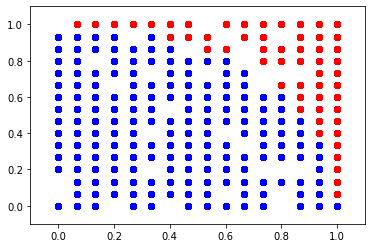

In [11]:
ALFG = MyRandom(6421893)
ALFG_pi = approximate_circle(ALFG.randfloat, 100000)
print(f"Approx. ALFG Pi: {ALFG_pi}\nDiff real Pi: {abs(ALFG_pi - pi)}")

### Python Random module
The Python module gets closer, this is to be expected. The Python Random Modue allows for more unique than the ALFG's meager 16 with the current setting.

Approx. py.Random Pi: 3.14092
Diff real Pi: 0.0006726535897931818


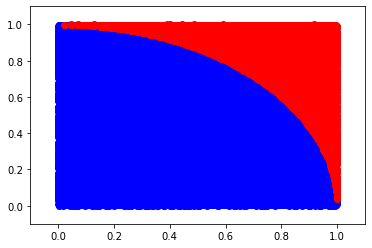

In [12]:
from random import random
py_pi = approximate_circle(random, 100000)
print(f"Approx. py.Random Pi: {py_pi}\nDiff real Pi: {abs(py_pi - pi)}")